In [55]:
import os
import av
import cv2

def generate_video(image_folder='.', fps=1):
    output_filename = os.path.join(image_folder, 'video.mp4')

    image_paths = sorted([img for img in os.listdir(image_folder) 
                          if img.endswith(".jpg") or
                             img.endswith(".jpeg") or
                             img.endswith(".png")],
                         key=lambda x: int(x.split('.')[0]))

    container = av.open(output_filename, "w")
    stream = container.add_stream("h264", fps)
    # Запись изображений в видео
    for image_path in image_paths:
        img = cv2.imread(os.path.join(image_folder, image_path))
        frame = av.VideoFrame.from_ndarray(img, format="rgb24")
        packet = stream.encode(frame)
        container.mux(packet)
    # Завершение записи видео
    packet = stream.encode(None)  # Посылаем None, чтобы завершить видеопоток
    container.mux(packet)
    # Закрытие видеопотока
    container.close()

    print(f"Видео сгенерировано: {output_filename}")

# Вызов функции генерации видео
generate_video(image_folder='data/out1')


Видео сгенерировано: data/out1/video.mp4


In [57]:
import numpy as np
import cv2
import subprocess

def decay(accumulator, decay_const):
    return accumulator / decay_const

def rejuvenate(fgmask, accumulator, rejuvenate_const):
    fgmask = np.where(fgmask > 0, 1, 0)
    fgmask = np.stack((fgmask,) * 3, axis=-1)
    return np.maximum(accumulator, fgmask * rejuvenate_const)

def process_video(input_file='input_video.mp4', output_file='out.mp4', output=False, decay_rate=1.01):
    video = cv2.VideoCapture(input_file)
    if not video.isOpened():
        print("Ошибка при открытии видеофайла.")
        return
    
    frame_shape = (int(video.get(4)), int(video.get(3)), 3)
    decay_const = np.full(frame_shape, [decay_rate, 1, 1])
    rejuvenate_const = np.full(frame_shape, [179, 225, 225])
    accumulator = np.full(frame_shape, [0, 225, 225])
    
    bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
    
    frames = []
    
    while video.isOpened():
        try:
            ok, frame = video.read()
            if not ok:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fgmask = bg_subtractor.apply(gray)
            accumulator = decay(accumulator, decay_const)
            accumulator = rejuvenate(fgmask, accumulator, rejuvenate_const)
            frame = cv2.cvtColor(accumulator.astype(np.uint8), cv2.COLOR_HSV2BGR)
            frames.append(frame)
        except KeyboardInterrupt:
            break
    
    if output:
        command = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'rawvideo',
            '-vcodec', 'rawvideo',
            '-s', f"{frame_shape[1]}x{frame_shape[0]}",  # size of one frame
            '-pix_fmt', 'bgr24',
            '-r', str(int(video.get(5))),  # frame rate of the input video
            '-i', '-',  # input comes from a pipe
            '-c:v', 'libx264',
            '-preset', 'ultrafast',
            '-crf', '25',  # constant rate factor
            output_file
        ]
        
        try:
            process = subprocess.Popen(command, stdin=subprocess.PIPE)
            for frame in frames:
                process.stdin.write(frame.tobytes())
            process.stdin.close()
            process.wait()
        except Exception as e:
            print("Ошибка при записи видео:", e)
            return
    
    video.release()
    return frames

images = process_video(input_file='data/out1/video.mp4', output_file='data/out1/motions.mp4', output=True, decay_rate=1.4)


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [56]:
from IPython.display import Video

Video("data/out1/video.mp4", width=800, height=450)

In [58]:
Video("data/out1/motions.mp4", width=800, height=450)

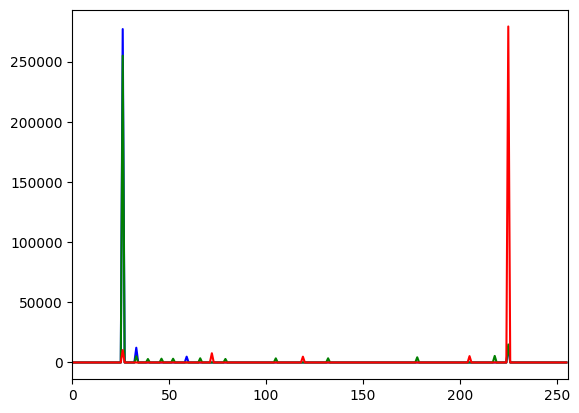

In [59]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = images[len(images)//2]
color = ('b','g','r')
plt.figure()
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
import cv2
import numpy as np

# Function to generate motion heatmap and save it as a video
def save_motion_heatmap(video_path, output_path, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2):
    """
    Generates a motion heatmap from a video file using the Farneback optical flow method.

    Parameters:
        video_path (str): Path to the input video file.
        output_path (str): Path to save the output motion heatmap video.
        pyr_scale (float): Scale factor for building the image pyramid. Default is 0.5.
        levels (int): Number of pyramid layers. Default is 3.
        winsize (int): Size of the averaging window for each pyramid level. Default is 15.
        iterations (int): Number of iterations at each pyramid level. Default is 3.
        poly_n (int): Size of the pixel neighborhood used to find polynomial expansion in each pixel. Default is 5.
        poly_sigma (float): Standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion. Default is 1.2.
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    # Get video frame properties
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'h264')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    hsv = np.zeros_like(frame1)
    hsv[..., 1] = 255

    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0)

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        out.write(bgr)

        prvs = next

    # Release video capture and writer objects
    cap.release()
    out.release()

# Example usage with custom parameters
save_motion_heatmap('data/out1/video.avi', 
                    'data/output_motions_4.mp4', 
                    pyr_scale=0.5, 
                    levels=5, 
                    winsize=10, 
                    iterations=5,
                    poly_n=7, 
                    poly_sigma=1.4)


OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
[ERROR:0@0.039] global cap_ffmpeg_impl.hpp:3130 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@0.039] global cap_ffmpeg_impl.hpp:3208 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


## Обучение

In [2]:
import pandas as pd 

df = pd.read_excel('data/out1/D03_20230523134844.mp4.xlsx')
df

,Unnamed: 0,minNegPressure,meanNegPressure,maxNegPressure,minHumidity,meanHumidity,maxHumidity,minT1,meanT1,maxT1,...,minT3,meanT3,maxT3,minT4,meanT4,maxT4,minT5,meanT5,maxT5,dt
0,0,-0.1,-0.1,-0.1,51.321667,52.065167,52.565167,33.500000,34.191333,34.795667,...,32.504333,33.134833,33.721833,31.800000,32.630500,33.161000,25.591333,26.443500,27.282667,2023-05-23 13:48:44
1,1,-0.1,-0.1,-0.1,51.421667,52.135167,52.635167,33.500000,34.151333,34.775667,...,32.524333,33.064833,33.591833,31.800000,32.540500,32.981000,25.551333,26.413500,27.202667,2023-05-23 13:49:44
2,2,-0.1,-0.1,-0.1,51.521667,52.205167,52.705167,33.500000,34.111333,34.755667,...,32.544333,32.994833,33.461833,31.800000,32.450500,32.801000,25.511333,26.383500,27.122667,2023-05-23 13:50:44
3,3,-0.1,-0.1,-0.1,51.621667,52.275167,52.775167,33.500000,34.071333,34.735667,...,32.564333,32.924833,33.331833,31.800000,32.360500,32.621000,25.471333,26.353500,27.042667,2023-05-23 13:51:44
4,4,-0.1,-0.1,-0.1,51.721667,52.345167,52.845167,33.500000,34.031333,34.715667,...,32.584333,32.854833,33.201833,31.800000,32.270500,32.441000,25.431333,26.323500,26.962667,2023-05-23 13:52:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,-0.1,-0.1,-0.1,52.400000,52.935940,53.507820,33.464060,34.228120,35.038270,...,32.782030,33.400000,34.100000,32.617970,33.282030,33.964060,25.228120,25.482030,25.635940,2023-05-23 14:51:44
64,64,-0.1,-0.1,-0.1,52.400000,52.915973,53.447920,33.484027,34.268053,35.128120,...,32.792013,33.400000,34.100000,32.607987,33.292013,33.984027,25.268053,25.492013,25.615973,2023-05-23 14:52:44
65,65,-0.1,-0.1,-0.1,53.085977,53.687980,54.097997,33.495993,34.291987,34.985977,...,32.700000,33.204007,34.002003,32.602003,33.102003,33.995993,25.291987,26.379967,26.779967,2023-05-23 14:53:44
66,66,-0.1,-0.1,-0.1,53.015860,53.627880,54.087980,33.475960,34.251920,34.915860,...,32.700000,33.224040,34.012020,32.612020,33.112020,33.975960,25.251920,26.279800,26.679800,2023-05-23 14:54:44


In [67]:
duration = len(df.index)
print(duration)

68


In [78]:
print(df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

    minNegPressure  meanNegPressure  maxNegPressure
0             -0.1             -0.1            -0.1
1             -0.1             -0.1            -0.1
2             -0.1             -0.1            -0.1
3             -0.1             -0.1            -0.1
4             -0.1             -0.1            -0.1
..             ...              ...             ...
63            -0.1             -0.1            -0.1
64            -0.1             -0.1            -0.1
65            -0.1             -0.1            -0.1
66            -0.1             -0.1            -0.1
67            -0.1             -0.1            -0.1

[68 rows x 3 columns]


In [106]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_series(label, x_axis, series_list):
    """
    Построение графика для списка pandas.Series

    Параметры:
    - x_axis: числовая ось, которая будет использоваться как ось X
    - series_list: список pandas.Series для построения графика
    """
    names = []
    for column_name, values in series_list.items():
        plt.plot(x_axis, values)
        names.append(column_name)
    plt.xlabel('X')
    plt.ylabel('Values')
    plt.title(label)
    plt.legend(names)
    
    plt.show()

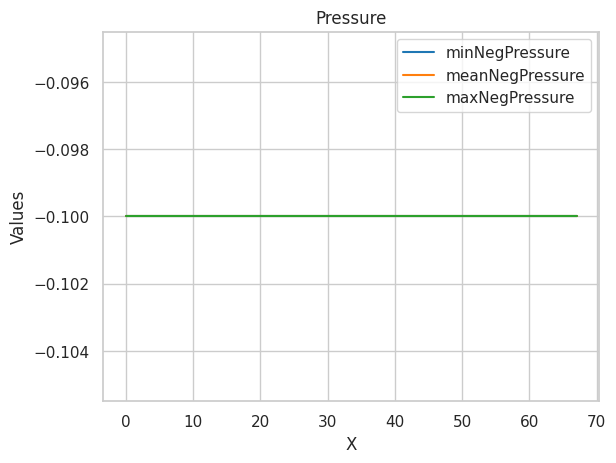

In [107]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Pressure', x_axis, series_list=df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

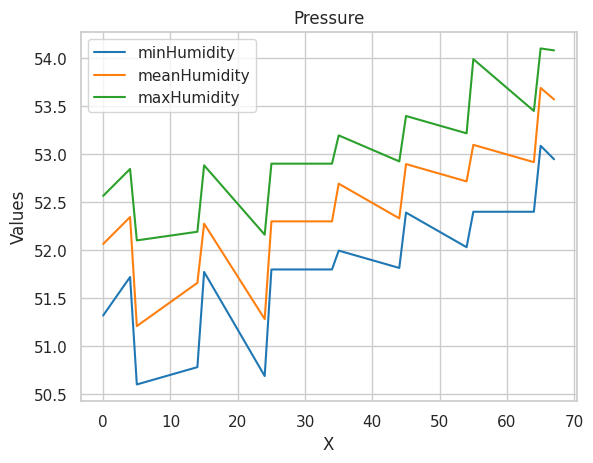

In [108]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Pressure', x_axis, series_list=df.loc[:, ['minHumidity', 'meanHumidity', 'maxHumidity']])

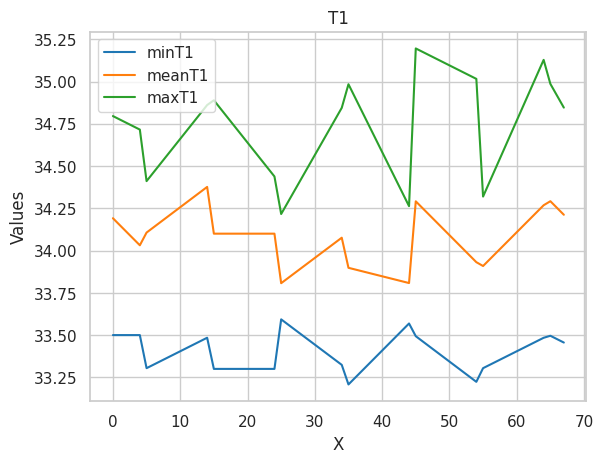

In [110]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T1', x_axis, series_list=df.loc[:, ['minT1', 'meanT1', 'maxT1']])

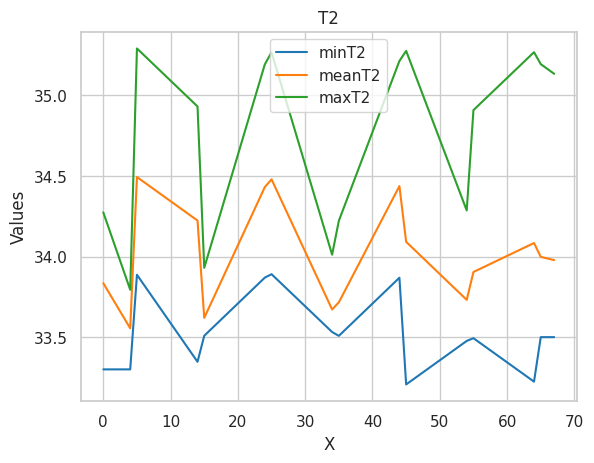

In [111]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T2', x_axis, series_list=df.loc[:, ['minT2', 'meanT2', 'maxT2']])

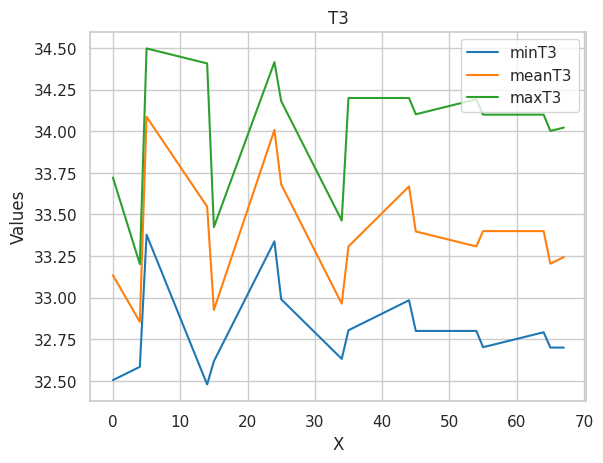

In [112]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T3', x_axis, series_list=df.loc[:, ['minT3', 'meanT3', 'maxT3']])

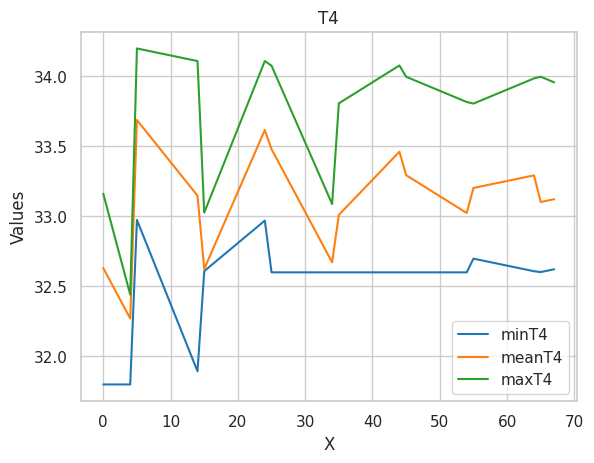

In [113]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T4', x_axis, series_list=df.loc[:, ['minT4', 'meanT4', 'maxT4']])

In [ ]:
def average_columns(df, columns):
    """
    Усредняет значения четырех колонок DataFrame.

    Параметры:
    - df: pandas.DataFrame
        Исходный DataFrame.
    - columns: list
        Список названий колонок, которые требуется усреднить.

    Возвращает:
    - pandas.Series
        Серия с усредненными значениями.
    """
    return df[columns].mean(axis=1)

## Попробуем усреднить значения с датчиков

In [ ]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T4', x_axis, series_list=df.loc[:, ['minT4', 'meanT4', 'maxT4']])